In [44]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from scipy import integrate
import matplotlib
from scipy.optimize import curve_fit
import source.tools._utils as ut
import source.tools._vid_tools as vut
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [2]:
def Dnu_from_Dz(nu,z,Dz):
    nuObs = nu/(1.+z)
    zmin = z-Dz/2.
    zmax = z+Dz/2.
    nu_zmin = nu/(1.+zmin)
    nu_zmax = nu/(1.+zmax)
    return nuObs, abs(nu_zmin-nu_zmax)


def lim_params(CO_model):
    cosmo_fid = dict(cosmo_input_camb={'H0':67.36,'ombh2':0.02237,'omch2':0.12,
                      'As':2.1e-9,'ns':0.9649,'mnu':0.06, 'f_NL':0})
    h=cosmo_fid['cosmo_input_camb']['H0']/100
    nu=115.271*u.GHz
    
    zObs=3
    Dz=1
    if CO_model=='COMAP':
        nuObs,Dnu=Dnu_from_Dz(nu,zObs,Dz)
        model_params = dict(nu=115.271*u.GHz, nuObs=nuObs,
                            sigma_scatter=0.42,
                            hmf_model='ST',
                            bias_model='ST99',
                            model_type='ML',
                            Mmin = 1e10*u.Msun, Mmax=1e15*u.Msun,
                            model_par={'A':-2.85,'B':-0.42,'C':10**10.63,'Ms':10**12.3*u.Msun},
                            model_name='COMAP_Fid',
                            do_onehalo=True, do_RSD=True, smooth=True,
                            kmin=1e-5*u.Mpc**-1, kmax=100*u.Mpc**-1,
                            nk=500, nmu=50, nM=1000,
                            Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                           dndL_Lcut=20*u.Lsun)
        obs_params = dict(Delta_nu=Dnu, dnu=31.25*u.MHz,
                          Tsys_NEFD=45*u.K/(69.4)**0.5, #We get the improvement here as an efficient way
                          Nfeeds=19*2,
                          beam_FWHM=4.5*u.arcmin,
                          tobs=1000*u.hr,
                          Omega_field=4*u.deg**2,
                          Nfield=1)
    elif CO_model=='Li2016':
        nuObs,Dnu=Dnu_from_Dz(nu,zObs,Dz)
        model_params = dict(nu=115.271*u.GHz, nuObs=nuObs,
                            sigma_scatter=0.3,
                            hmf_model='ST',
                            bias_model='ST99',
                            model_type='ML',
                            Mmin = 1e10*u.Msun, Mmax=1e15*u.Msun,
                            model_par={'alpha':1.37, 'beta':-1.74, 'dMF':1.0,'SFR_file':'/home-2/gsatopo1@jhu.edu/library/lim/SFR_tables/UM_sfr.dat','sig_SFR':0.3},
                            model_name='TonyLi',
                            do_onehalo=True, do_RSD=True, smooth=True,
                            kmin=1e-5*u.Mpc**-1, kmax=100*u.Mpc**-1,
                            nk=500, nmu=1000, nM=1000,
                            Tmin_VID=0.00001*u.uK,Tmax_VID=100*u.uK,nT=2**21,
                            Lmin=1e-2*u.Lsun,Lmax=1e10*u.Lsun,Ngal_max=30,
                           dndL_Lcut=20*u.Lsun)
        obs_params = dict(Delta_nu=Dnu, dnu=15.6*u.MHz,
                          Tsys_NEFD=40*u.K, #We get the improvement here as an efficient way
                          Nfeeds=95,
                          beam_FWHM=4*u.arcmin,
                          tobs=9000*u.hr,
                          Omega_field=2.25*u.deg**2,
                          Nfield=4)
        
    obs_params.update(model_params)
    obs_params.update(cosmo_fid)
    return obs_params

In [3]:
m_Li2016=lim(lim_params('Li2016'))
m_COMAP=lim(lim_params('COMAP'))

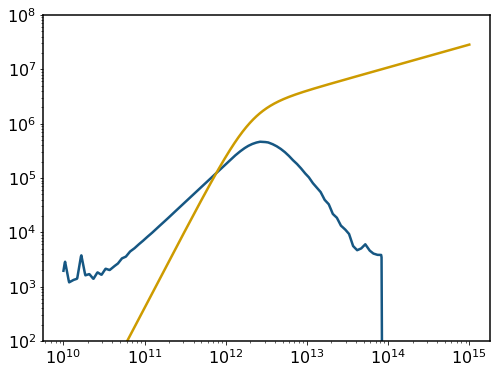

In [4]:
plt.loglog(m_Li2016.M, m_Li2016.LofM)
plt.loglog(m_COMAP.M, m_COMAP.LofM)
plt.ylim(1e2, 1e8)
plt.show()

In [58]:
def LC_params():
    h=0.678
    nu_CO=115.271*u.GHz
    zmin_CO = 2.5;zmax_CO = 3.5
    zmid_CO=(zmax_CO+zmin_CO)/2
    R=700
    dnu=nu_CO/(1+zmid_CO)/R
    model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                      lines=dict(CO_J10=True), target_line = 'CO_J10',
                      models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                              model_pars={'alpha':1.37,'beta':-1.74,'alpha_std':0,'beta_std':0,'sigma_L':0.3})),
                      LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, std_log10Ms_IRX=0.17, std_alpha_IRX=0.17,
                                      K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      supersample=1,
                      Nmu=20,
                      dk=0.02*u.Mpc**-1,
                      do_intensity=False,
                      seed=0)
    obs_params=dict(zmin = zmin_CO-0.03, zmax = zmax_CO+0.03,
                    RAObs_min=-1.75*u.deg,RAObs_max=1.75*u.deg,
                    DECObs_min=-1.75*u.deg,DECObs_max=1.75*u.deg,
                    RA_min=-1.75*u.deg,RA_max=1.75*u.deg,
                    DEC_min=-1.75*u.deg,DEC_max=1.75*u.deg,
                    nuObs_max=nu_CO/(1+zmin_CO), nuObs_min=nu_CO/(1+zmax_CO),
                    dnu=dnu,
                    Tsys=0*u.Jy/u.sr,
                    #Tsys=0*u.K,
                    #Tsys=(45*u.K/(69.4)**0.5)*np.sqrt(4/400),
                    Nfeeds=19*2,
                    beam_FWHM=2*u.arcmin,
                    tobs=1000*u.hr,
                    do_angular_smooth=False)
    obs_params.update(model_params)

    return obs_params

In [59]:
LC_CO=make_measurements(LC_params())

In [60]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC
inds_redshift=(LC_CO.nuObs_line_halo['CO_J10'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)
inds_SFR=(LC_CO.halo_catalog['SFR_HALO']>0)

inds = inds_SFR&inds_redshift&inds_sky

SM=LC_CO.halo_catalog['SM_HALO'][inds]
SFR=LC_CO.halo_catalog['SFR_HALO'][inds]

log10Ms_IRX,alpha_IRX=9.15, 0.97
std_log10Ms_IRX,std_alpha_IRX=0.17, 0.17
K_IR, K_UV=0.63*1.73e-10, 0.63*2.5e-10

log10Ms_IRX_sample,alpha_IRX_sample = np.random.multivariate_normal(np.asarray([log10Ms_IRX,alpha_IRX]),np.diag(np.asarray([std_log10Ms_IRX**2,std_alpha_IRX])), len(SM)).T
IRX = (SM/10**log10Ms_IRX_sample)**alpha_IRX_sample
LIR = SFR/(K_IR + K_UV/IRX)*u.Lsun
logM=np.log10(LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(LC_CO.Msunh).value)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

In [61]:
logM_bin=np.linspace(10, 13.5, 41)
meanLIR=[]
meanLIR_old=[]
meanSFR=[]
for i in range(len(logM_bin)-1):
    inds_M = (logM>=logM_bin[i])&(logM<logM_bin[i+1])
    Lbin_IR = LIR[inds_M]
    Lbin_IRold = 1e10 * SFR[inds_M]/1

    SFRbin = SFR[inds_M]
    meanLIR.append(np.mean(Lbin_IR).value)
    meanLIR_old.append(np.mean(Lbin_IRold))
    meanSFR.append(np.mean(SFRbin))

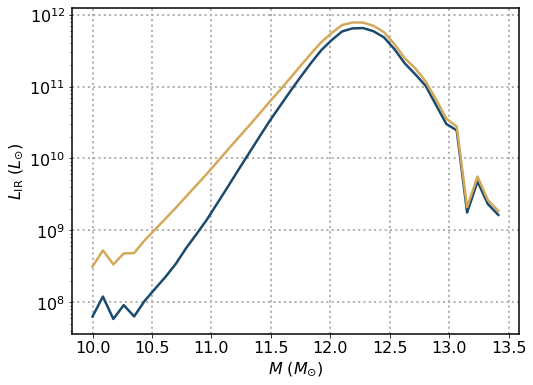

In [62]:
plt.plot(logM_bin[:-1], meanLIR)
plt.plot(logM_bin[:-1], meanLIR_old)
plt.ylabel(r'$L_{\rm IR}$ ($L_{\odot}$)')
plt.xlabel(r'$M$ $(M_{\odot})$')
plt.yscale('log')
plt.grid(linestyle='dotted', linewidth=2)

In [63]:
def LCO_mean(logM, alpha, beta):
    alpha_std, beta_std, sigma_L=0,0,0
    rng=np.random.default_rng(0)
    
    LCO = np.zeros(len(SFR))*u.Lsun
    std = np.random.multivariate_normal(np.array([alpha,beta]),np.diag(np.array([alpha_std**2,beta_std**2])),LIR.shape)
    alpha_par,beta_par = std[:,0],std[:,1]

    Lp = 10**((np.log10(LIR.value)-beta_par)/alpha_par)
    Lmean = (4.9e-5*u.Lsun)*Lp

    #Add scatter to the relation
    sigma_base_e = sigma_L*2.302585
    LCO = Lmean*rng.lognormal(-0.5*sigma_base_e**2, sigma_base_e, Lmean.shape)
    
    logM_bin=np.linspace(10.5, 13, 41)
    meanLCO=[]
    for i in range(len(logM_bin)-1):
        inds_M = (logM>=logM_bin[i])&(logM<logM_bin[i+1])
        Lbin = LCO[inds_M]
        meanLCO.append(np.mean(Lbin).value)
    return (logM_bin[1:]+logM_bin[:-1])/2, meanLCO

LM_COMAP=interp1d(np.log10(m_COMAP.M.value), m_COMAP.LofM.value)

alpha, beta=0.7, 4.5
Mbin, LCOmean=LCO_mean(logM, alpha, beta)

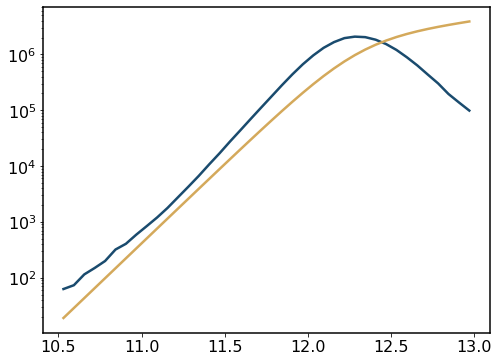

In [57]:
plt.plot(Mbin, LCOmean)
plt.plot(Mbin, LM_COMAP(Mbin))
plt.yscale('log')

In [7]:
inds_RA = (LC_CO.halo_catalog['RA'] > LC_CO.RAObs_min.value)&(LC_CO.halo_catalog['RA'] < LC_CO.RAObs_max.value)
inds_DEC = (LC_CO.halo_catalog['DEC'] > LC_CO.DECObs_min.value)&(LC_CO.halo_catalog['DEC'] < LC_CO.DECObs_max.value)
inds_sky = inds_RA&inds_DEC

inds = (LC_CO.nuObs_line_halo['CO_J10'] >= LC_CO.nuObs_min)&(LC_CO.nuObs_line_halo['CO_J10'] <= LC_CO.nuObs_max)&inds_sky
M_in_survey = LC_CO.halo_catalog['M_HALO'][inds]*LC_CO.Msunh.to(LC_CO.Msunh).value

logMcat_CO=np.log10(M_in_survey)
LCO = LC_CO.halos_in_survey['CO_J10']['Lhalo'].value
logM=np.linspace(np.min(logMcat_CO), np.max(logMcat_CO), 50)

meanLCO=[]
for i in range(len(logM)-1):
    inds = (logMcat_CO>=logM[i])&(logMcat_CO<logM[i+1])&(LCO>0)
    Lbin = LCO[inds]
    meanLCO.append(np.mean(Lbin))

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_161.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_162.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_163.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_164.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_165.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_166.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_167.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_168.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_169.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_170.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_171.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_172.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDP

In [54]:
grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/ipykernel/__main__.py:3: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  app.launch_new_instance()


Text(0, 0.5, '$\\log$(L$_{\\rm CO}$/L$_{\\odot}$)')

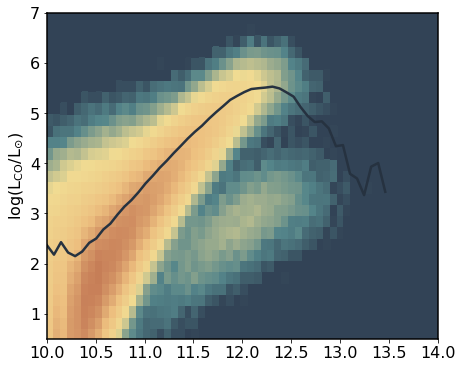

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,6))
ax.hist2d(logMcat_CO[LCO>0], np.log10(LCO[LCO>0]), bins=[50, 50], norm=mpl.colors.LogNorm(), 
                  cmap=cmap, density=True, vmin=1e-4, vmax=1)
ax.plot(logM[:-1], np.log10(meanLCO), color='#263240')
ax.set_facecolor(grey)
ax.set_ylim(0.5, 7)
ax.set_xlim(10, 14)
ax.set_ylabel(r'$\log$(L$_{\rm CO}$/L$_{\odot}$)')

In [49]:
#DATA 
logLCOdat = np.arange(9.5,11.01,0.1)+0.25
LCOwidth = np.ones((2,len(logLCOdat)))*0.25
logphi_max = np.array([-2.21,-2.69,-2.95,-3.12,-3.24,-3.32,-3.41,-3.37,-3.39,-3.45,-3.60,-3.70,-4.11,-4.25,-4.41,-4.45])
logphi_min = np.array([-4.04,-4.08,-4.14,-4.19,-4.23,-4.10,-4.07,-3.76,-3.69,-3.73,-3.98,-4.10,-4.79,-5.00,-5.44,-6.28])
logphidat = 0.5*(logphi_max+logphi_min)
logphiwidth = np.ones((2,len(logLCOdat)))*0.5*(logphi_max-logphi_min)

In [ ]:
def L_CO(logM, alpha, beta):
    alpha_std, beta_std, sigma_L=0,0,0
    rng=np.random.default_rng(0)
    
    LCO = np.zeros(len(SFR))*u.Lsun
    std = np.random.multivariate_normal(np.array([alpha,beta]),np.diag(np.array([alpha_std**2,beta_std**2])),LIR.shape)
    alpha_par,beta_par = std[:,0],std[:,1]

    Lp = 10**((np.log10(LIR.value)-beta_par)/alpha_par)
    Lmean = (4.9e-5*u.Lsun)*Lp

    #Add scatter to the relation
    sigma_base_e = sigma_L*2.302585
    LCO = Lmean*rng.lognormal(-0.5*sigma_base_e**2, sigma_base_e, Lmean.shape)
    
    logM_bin=np.linspace(10.5, 13, 41)
    meanLCO=[]
    for i in range(len(logM_bin)-1):
        inds_M = (logM>=logM_bin[i])&(logM<logM_bin[i+1])
        Lbin = LCO[inds_M]
        meanLCO.append(np.mean(Lbin).value)
    return (logM_bin[1:]+logM_bin[:-1])/2, meanLCO


Nhalos_fid, _=np.histogram(logLCOcat_UM_fid, bins=logLCO_UM_fid)
phi_UM_fid=Nhalos_UM_fid/np.diff(logLCO_UM_fid)[0]/((CO_UM_fid.Lbox[0]*CO_UM_fid.Lbox[1]*CO_UM_fid.Lbox[2]).to(u.Mpc**3))


In [48]:
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='r',
                     edgecolor='None', alpha=0.5):

    # Loop over data points; create box from errors at each point
    errorboxes = [rect((x - xe[0], y - ye[0]), xe.sum(), ye.sum())
                  for x, y, xe, ye in zip(xdata, ydata, xerror.T, yerror.T)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    artists = ax.add_collection(pc)
    ax.plot(0,0)

    return artists

(8.6, 12.1)

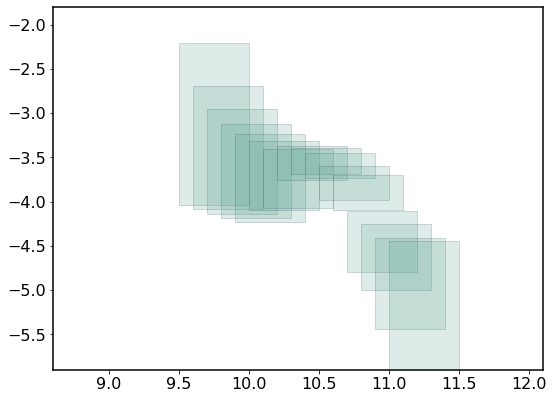

In [64]:
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle as rect
from matplotlib.collections import PatchCollection

gs = gridspec.GridSpec(1, 1,left=0.12,bottom=0.14,right=0.97,top=0.98,wspace=.0,hspace=.0)
fig = plt.figure(figsize=(8,6))

ax = plt.subplot(gs[0,0])

_ = make_error_boxes(ax,logLCOdat,logphidat,LCOwidth,logphiwidth,alpha=0.2, facecolor='#5ca191', edgecolor=grey)

plt.ylim(-5.9,-1.8)
plt.xlim(8.6,12.1)